In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import models
import utils

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

1f41e
1f98b


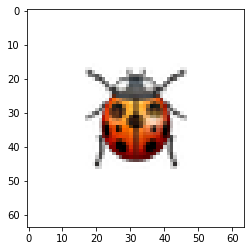

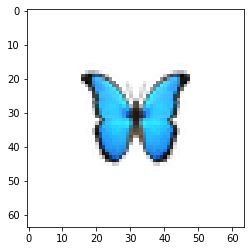

In [2]:
image_1 = utils.load_emoji("🐞",32,16).to(device)
image_2 = utils.load_emoji("🦋",32,16).to(device)

plt.imshow(image_1.transpose(0,2).cpu())
plt.show()
plt.imshow(image_2.transpose(0,2).cpu())
plt.show()

img_size = 64

In [10]:
n_channels = 16
n_epochs = 10000
lr = 0.001
pool_size = 1024
batch_size = 16
hidden_size = 128

images = torch.stack([image_1,image_2])

model = models.Automata((64, 64), n_channels, hidden_size, device).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

pool_initials = seed[None, :].repeat(pool_size,1,1,1)
pool_targets = image_1[None,:].repeat(pool_size,1,1,1)

pool_target_ids = torch.zeros(pool_size).long()
# 0 for image_1, 1 for image_2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
#     iterations = random.randint(64,96)
    iterations = 100

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:-batch_size//8]
    max_loss_indices = ranked_loss[-batch_size//8:]
    
    # switch the min-loss samples
    
#     for swap_idx in min_loss_indices:
#         pool_idx = pool_indices[swap_idx]
#         target_id = int(pool_target_ids[pool_idx])
        
#         # if output is the first image,
#         # switch the target to the second
#         if target_id == 1:
#             pool_targets[pool_idx] = image_2
#             pool_target_ids[pool_idx] = 2

#         # if output is the second image,
#         # keep it
#         if target_id == 2:
#             pool_targets[pool_idx] = image_2
#             pool_target_ids[pool_idx] = 2
    
    replacements = out.detach()
    replacements[max_loss_indices] = seed.clone()
    
    # high-loss outputs are re-tasked with
    # mapping the seed to the first image,
    
    # low-loss outputs are tasked with mapping
    # mapping to the other image
    pool_target_ids[pool_indices[max_loss_indices]] = 0
    pool_target_ids[pool_indices[min_loss_indices]] = 1-pool_target_ids[pool_indices[min_loss_indices]]
    
    pool_targets[pool_indices[max_loss_indices]] = images[0]
    pool_targets[pool_indices[min_loss_indices]] = images[pool_target_ids[pool_indices[min_loss_indices]]]

    pool_initials[pool_indices] = replacements

    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
        torch.save(model.state_dict(), "../models/metamorphosis_"+str(i))
        
    losses.append(float(total_loss))

0 -1.3949244423963556
100 -1.5808783792259795
200 -1.583651824864281
300 -1.5495125709051945
400 -1.6287245981070713
500 -1.7102589776491084
600 -1.6623665765408162
700 -1.7418284998324784
800 -1.9159134599941674
900 -2.1781853474035127
1000 -2.216384286620047
1100 -2.3136600894013806
1200 -2.5145604023869508
1300 -2.4689939378379333
1400 -2.4650257937456175
1500 -2.5287625128041262
1600 -2.6261544745237626
1700 -2.5961787499941313
1800 -2.7154378362151035
1900 -2.681959707489403
2000 -2.6321989060631843
2100 -2.6513461771016007
2200 -2.6721690224728043
2300 -2.6520316774395725
2400 -2.810540042541441
2500 -2.6205263807076014
2600 -2.8510228028708307
2700 -2.756260982610984
2800 -2.743134267405235
2900 -2.6960237918399765
3000 -2.8001185211877697
3100 -2.771973024412354
3200 -2.807156350444187
3300 -2.9363569471189943
3400 -2.842417258723199
3500 -3.0680399213614806
3600 -2.9742212725510413
3700 -3.040453509470215
3800 -3.060104429269502
3900 -3.0109622102110767
4000 -3.069706840328151

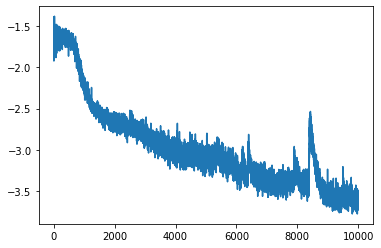

In [11]:
plt.plot(np.log10(losses))

In [12]:
with torch.no_grad():
    out = model(seed[None,:],1024,keep_history=True)
    video = model.history.cpu().detach()
    video = video[:,0,:4]
    video = video.transpose(1,3)

from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
